# 1D Burgers equation on a periodic domain

The [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation) is a Partial Differential Equation (PDE) that describes convection and diffusion. It can also be viewed as a simplified version of the [Navier-Stokes equation](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations). Here, we start with the equation in the following form:

$\frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}=\nu \frac{\partial^2 u}{\partial x^2}$

on the domain $x \in [0, L]$ and $0 \le t \le T$. The domain is considered periodic in $x$. And the initial condition is given by:

$u(x,t=0) = 1.0 + 0.5 \cos(2\pi/L x)$ 



In [1]:
# goto folder of this notebook (If you move this notebook then also copy the Project.toml file and run instantiate to install the packages)
cd(@__DIR__)
# load the environment
using Pkg 
Pkg.activate(".")  # activate the environment for this notebook
# load the packages
using OrdinaryDiffEq
using ComponentArrays
using Plots
using JLD2


  Activating project at `~/dellete/src/julia_ml_tests.jl.git/model_1d`


In [2]:
# Load model from file
include("../model_1d/model_1d_burgers.jl")



burgers_initial_condition (generic function with 3 methods)

In [9]:
# setting up the problem

# parameters
nx=100     # number of spatial points
L=10.0     # length of the domain
Δx=L/nx    # spatial step
ν=0.1      # viscosity
k=2*pi/L   # wave number for initial condition
u_mean=1.0 # mean velocity
u_amplitude=0.5 # amplitude of the initial condition
p=()       # parameters (not used in this case)

# spatial grid
x=Δx*(1:nx) # spatial grid points

# initial condition
u0 = burgers_initial_condition(x,k,u_mean,u_amplitude)

# initialize model struct
f=burgers_equation(Δx, ν, similar(u0), similar(u0))

# time span
t_start=0.0
t_end=5.0


5.0

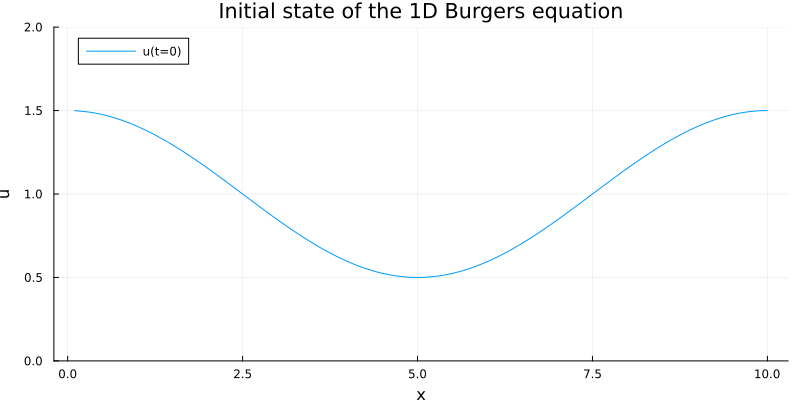

In [10]:
# plot the initial state
p1=plot(x, u0, label="u(t=0)", xlabel="x", ylabel="u")
plot(p1, size=(800,400), title="Initial state of the 1D Burgers equation",ylim=(0, 2))

In [11]:
prob = ODEProblem(f, u0, (t_start, t_end))
@time sol = solve(prob, Tsit5(),saveat=10.0) # with timing, but ouput only at t=10.0
sol = solve(prob, Tsit5()) # store output, no timing

nothing

  0.944319 seconds (3.95 M allocations: 216.753 MiB, 4.99% gc time, 99.98% compilation time)


┌ Info: Saved animation to /home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/burgers1d_periodic.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/uiCPf/src/animation.jl:156


  1.142558 seconds (630.51 k allocations: 32.713 MiB, 28.12% compilation time: 13% of which was recompilation)


Plots.AnimatedGif("/home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/burgers1d_periodic.gif")
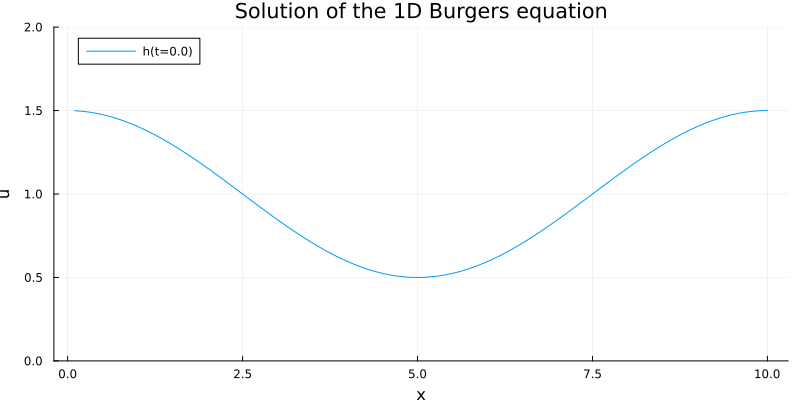

In [12]:
# create a movie of the solution
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(sol.t)
        p1 = plot(x, sol[i], label="h(t=$(round(sol.t[i],digits=2)))", xlabel="x", ylabel="u", ylim=(0, 2))
        plot(p1, size=(800,400), title="Solution of the 1D Burgers equation")
    end
    gif(anim, "burgers1d_periodic.gif", fps=15)
end


In [13]:
# save the solution to a JLD2 file
cfl_out=1.0 # CFL number for output
dt_out=cfl_out*f.Δx/u_mean # time step for output, based on CFL condition
times=collect(0.0:dt_out:t_end) # output times
solution=[]
for t in times
    push!(solution, sol(t))
end
# save the solution to a JLD2 file
save("burgers1d_periodic.jld2", 
    "solution", solution,
    "times", times,
    "params", (ν=ν, Δx=Δx, u_mean=u_mean, u_amplitude=u_amplitude, k=k),
    "grid", x,
    "cfl_out", cfl_out,
    "dt_out", dt_out,
    "description", "Solution of the 1D Burgers equation with periodic boundary conditions, using a cosine as initial condition.")


In [ ]:
# load the solution from the JLD2 file for testing
ff=load("burgers1d_periodic.jld2")

@show ff["solution"][1][1:20:end] # show some values of the initial velocity field

((ff["solution"])[1]).h[1:20:end] = [1.9287498479639178e-22, 1.2664165549094176e-14, 1.522997974471263e-8, 0.00033546262790251185, 0.1353352832366127, 1.0, 0.1353352832366127, 0.00033546262790251185, 1.522997974471263e-8, 1.2664165549094176e-14]


10-element Vector{Float64}:
 1.9287498479639178e-22
 1.2664165549094176e-14
 1.522997974471263e-8
 0.00033546262790251185
 0.1353352832366127
 1.0
 0.1353352832366127
 0.00033546262790251185
 1.522997974471263e-8
 1.2664165549094176e-14